# GRU Model

## Import Libraries

In [1]:
# Common Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import joblib
from tqdm import tqdm
from copy import deepcopy
from IPython.display import clear_output
import time
import random
import json

# Deep learning libraries
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch import inf

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Hyper Parameter Tuning
import optuna
from optuna.trial import TrialState

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error,  root_mean_squared_error, r2_score

# Project Path
project_path = "../"

# Project Seed for Reproducability
SEED = random.randint(0, 2**32 - 1)  # Random integer between 0 and 2^32-1
print(f"seed: {SEED}")

seed: 755408091


## GPU Selection

In [2]:
# Detect available device
if torch.cuda.is_available():
    # check if ROCm backend is active
    if torch.version.hip is not None:
        backend = "ROCm"
    else:
        backend = "CUDA"

    device = torch.device("cuda")
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Backend: {backend}")
else:
    device = torch.device("cpu")
    print("PyTorch is not using GPU — running on CPU")


PyTorch is using GPU: AMD Radeon Graphics
Backend: ROCm


In [3]:
device = torch.device("cpu")

## Import Data

In [4]:
data_path = os.path.join(project_path, "data/raw_data.csv")
data = pd.read_csv(data_path, sep = ",")

## Preprocessing

### Split Data to Train, Test, and Val

In [5]:
data_length = len(data)

train_size = int(data_length * 0.8) #80% train
val_size = int(data_length * 0.1) #10% validation
test_size = data_length - train_size - val_size  # the remaining data

train = data[0:train_size]
validation = data[train_size:train_size + val_size]
test = data[train_size + val_size:]

len(train)/data_length, len(validation)/data_length, len(test)/data_length

(0.799893983567453, 0.09992048767558971, 0.10018552875695733)

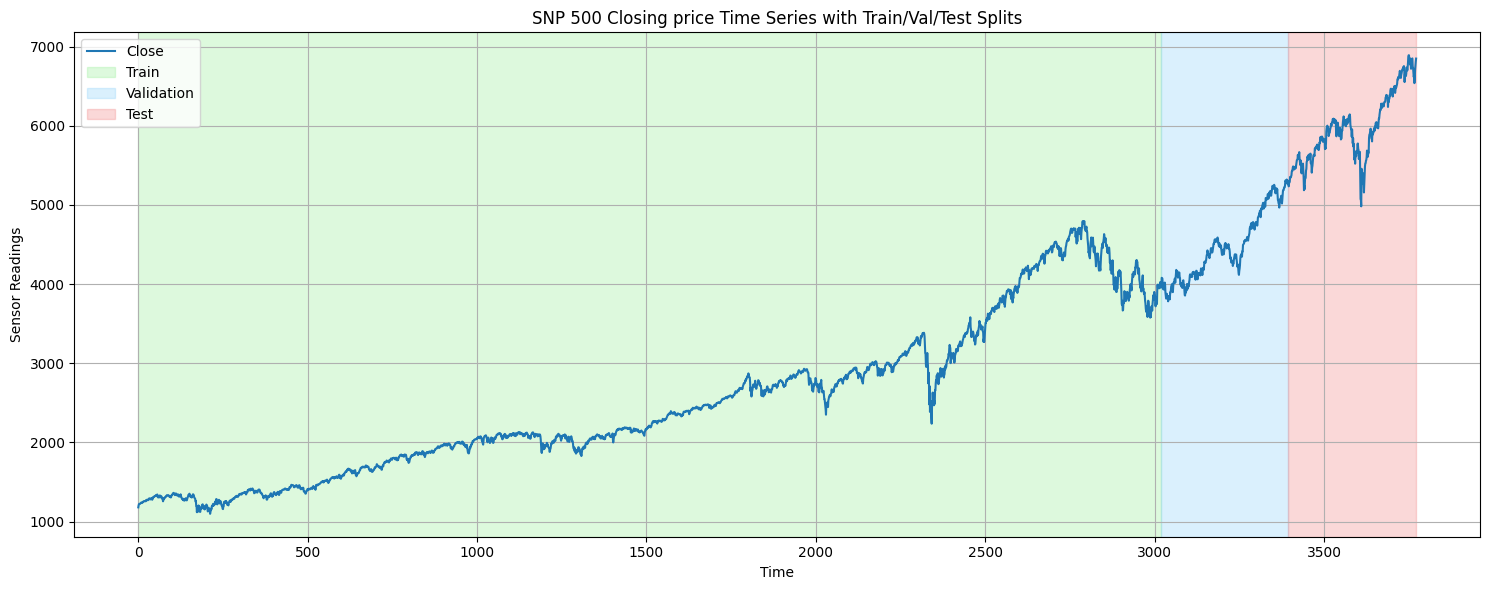

In [6]:
# Select the target features to plot
columns_to_plot = ['Close']

# Split indexes
data_length = len(data)
train_end = int(data_length * 0.8)
val_end = int(data_length * 0.9)

# Plot
plt.figure(figsize=(15, 6))

# Plot each feature
for col in columns_to_plot:
    plt.plot(data.index, data[col], label=col, linewidth=1.5)

# Highlight train, val, test regions
plt.axvspan(data.index[0], data.index[train_end], color='lightgreen', alpha=0.3, label='Train') #avx span to draw shaded backgrounds
plt.axvspan(data.index[train_end], data.index[val_end], color='lightskyblue', alpha=0.3, label='Validation')
plt.axvspan(data.index[val_end], data.index[-1], color='lightcoral', alpha=0.3, label='Test')

plt.xlabel("Time")
plt.ylabel("Sensor Readings")
plt.title("SNP 500 Closing price Time Series with Train/Val/Test Splits")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Shifting

the window size would be 90 days or 3 quarters

In [7]:
def create_sequences(data, window_size):
    X, y = [], []

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])

    return np.array(X), np.array(y)


In [8]:
#get the numeric columns
numeric_cols = ["Close"]
window_size = 90 # 3 quarters

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Close']])
val_scaled   = scaler.transform(validation[['Close']])
test_scaled  = scaler.transform(test[['Close']])

x_train, y_train = create_sequences(train_scaled, window_size= window_size)
x_val, y_val     = create_sequences(val_scaled, window_size= window_size)
x_test, y_test   = create_sequences(test_scaled, window_size= window_size)

## Data Loader

In [9]:
batch_size = 32

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Making

### Model Builder

In [10]:
def define_model(trial, input_size, n_output):
    class GridGRU(nn.Module):
        def __init__(self, trial, input_size: int, hidden_size: int, num_layers: int, n_output: int):
            super().__init__()

            def dense_layer_builder(layer_prefix):
                nonlocal input_size, dense_layers

                # Dense layer parameters
                out_size = trial.suggest_int(f"{layer_prefix}_output_size", 32, 512)
                dense_layers.append(nn.Linear(input_size, out_size))

                # Add drop out rate so that it reduces overfitting and improve generlization
                dropout_rate = trial.suggest_float(f"{layer_prefix}_dropout_rate", 0.0, 0.8)
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate)) # Update input size for the next dense layer based on the output size of this one

                input_size = out_size

            if num_layers >= 2:
                gru_dropout = trial.suggest_float("gru_dropout", 0.0, 0.8)
            else:
                gru_dropout = 0
                trial.set_user_attr("gru_dropout", gru_dropout)

            self.hidden_size = hidden_size
            self.num_layers = num_layers

            self.gru = nn.GRU(
                input_size = input_size,
                hidden_size = hidden_size, #number of gru Blocks
                num_layers = num_layers, #number of gru layers
                batch_first = True, # so that pytorch recognizes the input to be [batch_size, sequence_length, input_size] otherwise [sequence_length, batch_size, input_size]
                dropout = gru_dropout
            )

            # Make the dense layers
            dense_layers = []
            input_size = hidden_size
            n_dense_layers = trial.suggest_int("n_dense_layer", 1, 25)

            for i in range(n_dense_layers):
                dense_layer_builder(f"dense_{i}") #input size would be updated each iteration

            #output Layer
            dense_layers.append(nn.Linear(input_size, n_output))

            # Register dense layers as nn.Sequential
            self.dense = nn.Sequential(*dense_layers)

        def forward(self, input_tensor): # Forward pass
            batch_size = input_tensor.size(0)
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(input_tensor.device)
            out, _ = self.gru(input_tensor, h0)
            out = self.dense(out[:, -1, :])
            return out

    hidden_size = trial.suggest_int("gru_hidden_size", 8, 512)
    num_layers = trial.suggest_int("gru_num_layers", 1, 6)
    return GridGRU(trial, input_size, hidden_size, num_layers, n_output)


## Optuna Objective

In [11]:
def objective(trial, n_input, n_output, train_loader, val_loader, epochs, device):
    # Reset the seed for each trial of the gridsearch
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Parameters for early stopping
    best_mse = inf # Inital MSE score
    patience = 3 # number of epochs to wait without improvement before stopping
    epochs_no_improve = 0 # Epochs counter without improvement
    best_model_state = None # To store the best model weights

    # Model Initialization
    model = define_model(trial, n_input, n_output).to(device)

    # Learning rate
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)  # log-scale search

    # Optimizer Set-Up
    optimizer_name = trial.suggest_categorical("Optimizer", ["Adam", "Momentum", "AdamW"])
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "Momentum": optim.SGD(model.parameters(),
                            lr=lr,
                            momentum=trial.suggest_float("sgd_momentum", 1e-5, 1, log=True)),
        "AdamW": optim.AdamW(model.parameters(),
                            lr=lr,
                            weight_decay=trial.suggest_float("adamw_weight_decay", 1e-5, 1, log=True))
    }[optimizer_name]

    # Loss function
    loss_function = nn.MSELoss() # This is to punish the model for large errors

    for epoch in tqdm(range(epochs), desc="Training model..."):
        # Training loop
        model.train()
        for inputs, true_values in train_loader:
            inputs, true_values = inputs.to(device), true_values.to(device) # Set the device to train on

            optimizer.zero_grad() # Resets all the gradients since pytorch accumulates gradients from previous training
            outputs = model(inputs) # Runs a forward pass
            loss = loss_function(outputs.view(-1), true_values.view(-1)) # Calculates the error
            loss.backward() # Runs a Backward pass
            optimizer.step() # Updates model trainable parameters

        # Early Stopping Check
        # Validation (after training loop finishes)
        model.eval() # Make model in evaluation mode
        all_preds = [] # For the model predictions and true lables
        all_labels = []

        with torch.no_grad(): # Turns off gradient tracking for speeding up validation, saves memory, lock memory weights
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device).float() # move lables to the device
                outputs = model(inputs) # Pass input data to the model to get raw logits

                all_preds.extend(outputs.squeeze().cpu().numpy()) # move the predictions and lables to the cpu since numpy only works on CPU memory. then convert to numpy arrays then append to the list.
                all_labels.extend(labels.squeeze().cpu().numpy())

        # Calculate MSE Score
        curr_mse = mean_squared_error(all_labels, all_preds) # Calculate mse score

        if curr_mse < best_mse:
            best_mse = curr_mse
            epochs_no_improve = 0
            best_model_state = deepcopy(model.state_dict()) # Save the model state
            clear_output(wait=True)
            tqdm.write(f"Current_MSE: {curr_mse}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                tqdm.write(f"Early stopping at epoch {epoch} \n MSE: {curr_mse}")
                break

    # Load best model weights for reporting
    model.load_state_dict(best_model_state)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad(): # Turns off gradient tracking for speeding up validation, saves memory, lock memory weights
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # move lables to the device
            outputs = model(inputs) # Pass input data to the model to get raw logits

            all_preds.extend(outputs.squeeze().cpu().numpy()) # move the predictions and lables to the cpu since numpy only works on CPU memory. then convert to numpy arrays then append to the list.
            all_labels.extend(labels.squeeze().cpu().numpy())

    best_mse = mean_squared_error(all_labels, all_preds)
    tqdm.write(f"Trial {trial.number}: Best MSE Score = {best_mse:.4f}")
    trial.set_user_attr("best_model_state", best_model_state)
    return best_mse

### Initiate Hyper Parameter Tuning

In [12]:
# The input size
input_size = x_train.shape[2]

# Get number of outputs
output_size = 1 # since this is regression there would be only 1 output
epochs = 3
n_trials = 10

samplers = optuna.samplers.TPESampler(n_startup_trials=10) # Bayesian optimization method used by Optuna to sample hyperparameters intelligently (20 random trials first before starting the Bayesian optimization.)
study = optuna.create_study(direction="minimize", sampler=samplers) # Minimize MSE score

for _ in tqdm(range(n_trials), desc="Optuna (TPE) search ..."):
    time.sleep(0.8) #wait for .8 seconds befor clearing the output
    clear_output(wait=True) # comment this out of you want to see the whole training process
    study.optimize(lambda trial: objective(trial,input_size, output_size, train_loader,
                                            val_loader, epochs, device),
                    n_trials=1)

# Summarize study results
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED]) # get the pruned trials
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]) # get the succeeded trials

print("\nstudy statistics:")
print(f"  Finished trials: {len(study.trials)}")
print(f"  Pruned trials:   {len(pruned_trials)}")
print(f"  Complete trials: {len(complete_trials)}")

# Define model with best params
best_trial = study.best_trial
print("Best trial:")
print(f"  Best MSE: {best_trial.value:.4f}")
best_model = define_model(best_trial, input_size, output_size).to(device)

# Load best weights
best_model.load_state_dict(best_trial.user_attrs["best_model_state"])

                                                                       
Optuna (TPE) search ...:  90%|█████████ | 9/10 [08:41<00:55, 55.77s/it]

Current_MSE: 0.06269831502814327


Optuna (TPE) search ...: 100%|██████████| 10/10 [09:41<00:00, 58.13s/it]

Trial 9: Best MSE Score = 0.0627

study statistics:
  Finished trials: 10
  Pruned trials:   0
  Complete trials: 10
Best trial:
  Best MSE: 0.0100


<All keys matched successfully>

## Model Evaluation

### Model Builder from Parameters

In [17]:
# Model Builder from Parameters
def define_model_from_params(params: dict, input_size: int, n_output: int):
    class GridGRU(nn.Module):
        def __init__(self):
            super().__init__()

            self.hidden_size = params["gru_hidden_size"]
            self.num_layers = params["gru_num_layers"]
            self.gru_dropout = params.get("gru_dropout", 0.0)

            self.gru = nn.GRU(
                input_size=input_size,
                hidden_size=self.hidden_size,
                num_layers=self.num_layers,
                batch_first=True,
                dropout=self.gru_dropout
            )
            # Build dense layers
            dense_layers = []
            dense_input_size = self.gru.hidden_size
            n_dense_layers = params.get("n_dense_layer", 1)

            for i in range(n_dense_layers):
                out_size = params[f"dense_{i}_output_size"]
                dense_layers.append(nn.Linear(dense_input_size, out_size))

                dropout_rate = params.get(f"dense_{i}_dropout_rate", 0.0)
                if dropout_rate > 0:
                    dense_layers.append(nn.Dropout(dropout_rate))

                dense_input_size = out_size

            # Output layer
            dense_layers.append(nn.Linear(dense_input_size, n_output))
            self.dense = nn.Sequential(*dense_layers)

        def forward(self, input_tensor):
            if input_tensor.dim() == 2:  # [batch_size, input_size]
                input_tensor = input_tensor.unsqueeze(1)  # make it [batch_size, seq_len=1, input_size]

            batch_size = input_tensor.size(0)

            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

            # GRU Forward pass
            out, _ = self.gru(input_tensor, h0) # out: [batch_size, seq_len, hidden_size]
            out = self.dense(out[:, -1, :]) # take the last time step and pass it to the dense layer
            return out

    return GridGRU()


### Model Evalutation Function

In [18]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()

            outputs = model(inputs)

            all_preds.extend(outputs.squeeze(-1).cpu().numpy())
            all_labels.extend(labels.squeeze(-1).cpu().numpy())

    if len(all_preds) == 0:
        raise ValueError("No samples available for evaluation.")

    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = root_mean_squared_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    return mse, mae, rmse, r2, all_labels, all_preds

### Export and Evaluate Model

In [19]:
model_pytorch_path = os.path.join(project_path,"models/gru/gru_model.pt")
model_json_path = os.path.join(project_path,"models/gru/gru_model.json")
seed_path = os.path.join(project_path,"models/gru/seed.txt")
new_model = best_model.to(device)
new_model.eval()

# Evaluate new model on test set
new_mse, new_mae, new_rmse, new_r2, labels, predicitons = evaluate_model(
                                    new_model,
                                    test_loader,
                                    device
                                    )

if os.path.exists(model_pytorch_path) and os.path.exists(model_json_path):
    # Load the existing (old) model
    with open(model_json_path, "r") as f:
        best_old_params = json.load(f)

    old_model = define_model_from_params(best_old_params, input_size, output_size).to(device)
    old_model.load_state_dict(torch.load(model_pytorch_path, map_location=device))
    old_model.eval()

    # Evaluate the old model
    old_mse, old_mae, old_rmse, old_r2, old_labels, old_predictions = evaluate_model(
                                        old_model,
                                        test_loader,
                                        device
                                        )
    print("Model Scores:")
    print(f"Old_mse       = {old_mse:.4f}     | New_mse       = {new_mse:.4f}")
    print(f"Old_mae       = {old_mae:.4f}     | New_mae       = {new_mae:.4f}")
    print(f"Old_rmse      = {old_rmse:.4f}    | New_rmse      = {new_rmse:.4f}")
    print(f"Old_r²        = {old_r2:.4f}      | new_r²        = {new_r2:.4f}")

    print()
    print()
    if new_mse < old_mse:
        print("🔁 New model is better — overwriting saved model.")
        torch.save(new_model.state_dict(), model_pytorch_path)

        with open(model_json_path, "w") as f:
            save_dict = {
                            "params": best_trial.params,
                            "user_attrs": best_trial.user_attrs
                        }

        json.dump(save_dict, f, indent=4)

        with open(seed_path, "w") as file:
            file.write(str(SEED))

        model = new_model
    else:
        print("✅ Existing model is still better.")
        model = old_model
else:
    print("Model Score:")
    print(f"New_mse       = {new_mse:.4f}")
    print(f"New_mae       = {new_mae:.4f}")
    print(f"New_rmse      = {new_rmse:.4f}")
    print(f"new_r²        = {new_r2:.4f}")
    print()
    print()
    print("📥 No existing model — saving new model.")
    os.makedirs(os.path.join(project_path, "models/gru/"), exist_ok=True)
    torch.save(new_model.state_dict(), model_pytorch_path)
    with open(model_json_path, "w") as f:
        json.dump(best_trial.params, f, indent=4)
    with open(seed_path, "w") as file:
        file.write(str(SEED))
    model = new_model


Model Scores:
Old_mse       = 0.1771     | New_mse       = 0.1771
Old_mae       = 0.4064     | New_mae       = 0.4064
Old_rmse      = 0.4208    | New_rmse      = 0.4208
Old_r²        = -13.8989      | new_r²        = -13.8989


✅ Existing model is still better.


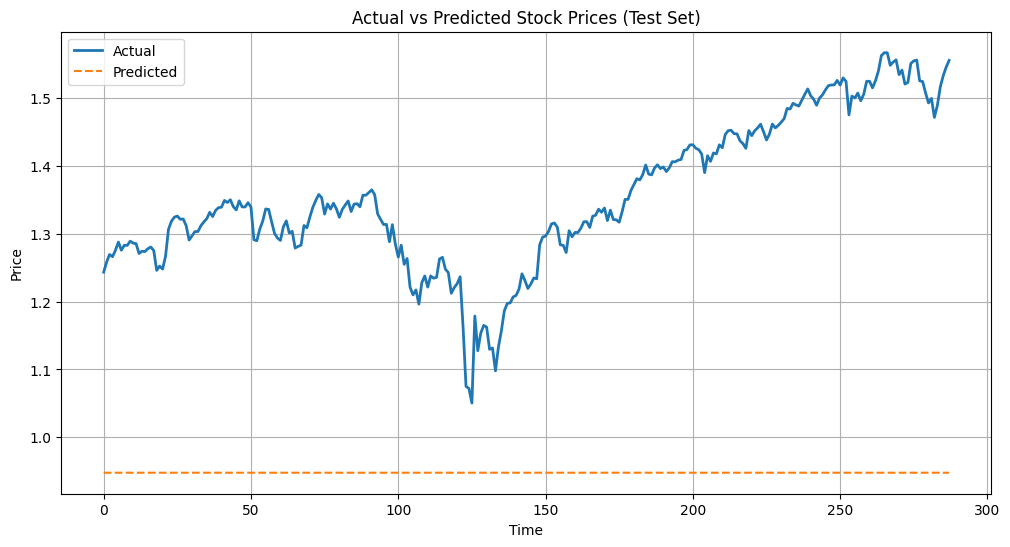

In [20]:
_, _, _, _, old_labels, old_predictions = evaluate_model(
                                        model,
                                        test_loader,
                                        device
                                        )

plt.figure(figsize=(12, 6))
plt.plot(labels, label="Actual", linewidth=2)
plt.plot(predicitons, label="Predicted", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs Predicted Stock Prices (Test Set)")
plt.legend()
plt.grid(True)
plt.show()